### Data pre-processing
In this file, the dataset is processed to make it suitable for the subsequent machine learning analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
df = pd.read_csv('weather.csv')

In [3]:
# dataframe column names
print(df.columns)

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')


In [5]:
#print(df.head())

In [6]:
# numeric and categoric columns
numeric_cols = df.select_dtypes(include=[np.number])
numeric_cols = numeric_cols.drop(numeric_cols.columns[0], axis=1)
categoric_cols = df.select_dtypes(include='object').columns.tolist()
categoric_cols = pd.Index(categoric_cols).delete([0, 1])

In [7]:
print("Numeric columns: ", numeric_cols.columns)
print("\nCategoric columns: ", categoric_cols)

Numeric columns:  Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RISK_MM'],
      dtype='object')

Categoric columns:  Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')


#### Missing and null data analysis

In [8]:
# missing numeric data
def missing_numeric_data(df, numeric_cols):
    missing_data = df.isnull().sum()
    print("Missing data per column:")
    print(missing_data)
    plt.figure(figsize=(10, 5))
    plt.bar(missing_data.index, missing_data.values)
    plt.xticks(rotation=90)
    plt.xlabel("Columns")
    plt.ylabel("Missing data")
    plt.title("Missing data per column")
    plt.show()

# missing categoric data
def missing_categoric_data(df, categoric_cols):
    missing_data = df[categoric_cols].isnull().sum()
    print("Missing data per column:")
    print(missing_data)
    plt.figure(figsize=(10, 5))
    plt.bar(missing_data.index, missing_data.values)
    plt.xticks(rotation=90)
    plt.xlabel("Columns")
    plt.ylabel("Missing data")
    plt.title("Missing data per column")
    plt.xticks(rotation=15)
    plt.show()
    
def nan_values_check(df):
    num_nan = df.isnull().sum()
    return num_nan

Missing data per column:
Unnamed: 0           0
Date                 0
Location             0
MinTemp            331
MaxTemp            176
Rainfall           279
Evaporation      15568
Sunshine         18336
WindGustDir       3457
WindGustSpeed     3455
WindDir9am        3072
WindDir3pm        1733
WindSpeed9am       572
WindSpeed3pm      1230
Humidity9am        391
Humidity3pm       1064
Pressure9am       4828
Pressure3pm       4827
Cloud9am         10864
Cloud3pm         11185
Temp9am            245
Temp3pm            918
RainToday          279
RISK_MM              0
RainTomorrow         0
dtype: int64


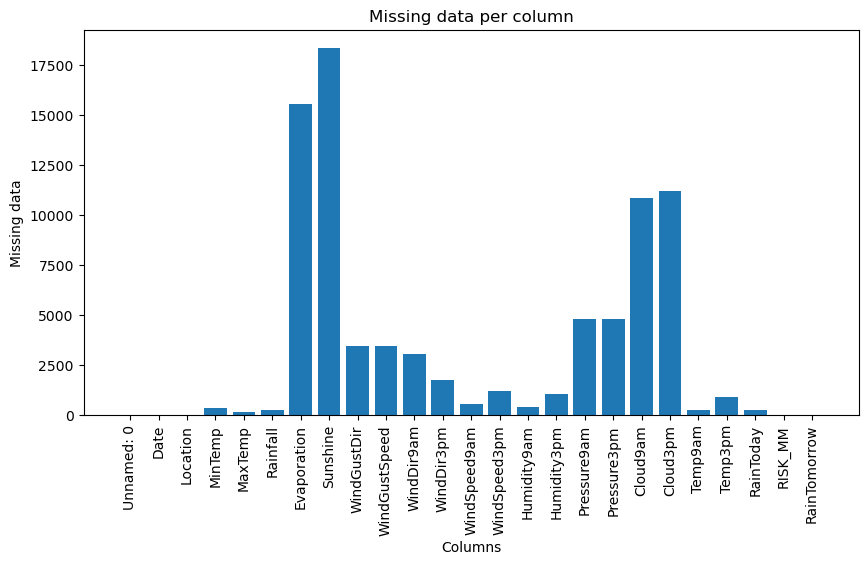

In [9]:
missing_numeric_data(df, numeric_cols)

Missing data per column:
WindGustDir     3457
WindDir9am      3072
WindDir3pm      1733
RainToday        279
RainTomorrow       0
dtype: int64


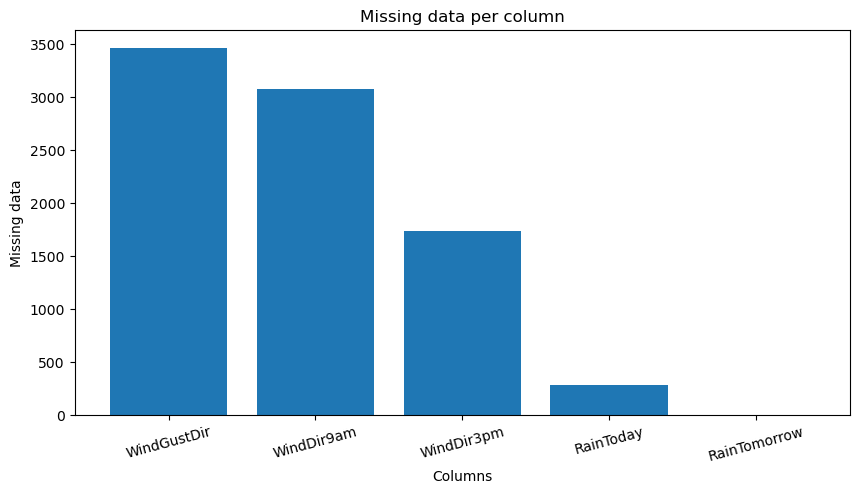

In [10]:
missing_categoric_data(df, categoric_cols)

In [11]:
print(nan_values_check(df))

Unnamed: 0           0
Date                 0
Location             0
MinTemp            331
MaxTemp            176
Rainfall           279
Evaporation      15568
Sunshine         18336
WindGustDir       3457
WindGustSpeed     3455
WindDir9am        3072
WindDir3pm        1733
WindSpeed9am       572
WindSpeed3pm      1230
Humidity9am        391
Humidity3pm       1064
Pressure9am       4828
Pressure3pm       4827
Cloud9am         10864
Cloud3pm         11185
Temp9am            245
Temp3pm            918
RainToday          279
RISK_MM              0
RainTomorrow         0
dtype: int64


#### Data cleaning and reduction
Functions to remove useless columns, fill by mean values, fill by most common value, remove rows with no prediction (i.e. "RainTomorrow" values).

In [12]:
def remove_columns(df, columns):
    return df.drop(columns=columns, inplace=False)

def fill_missing_values_with_mean(df, columns, groupby):
    for col in columns:
        df[col] = df.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
    return df

def fill_missing_values_with_mode(df, columns, groupby=None):
    for col in columns:
        if groupby is not None:
            df[col] = df.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    return df

def remove_rows_with_missing_values(df, subset):
    return df.dropna(subset=subset, inplace=False)

def check_missing_values(df):
    if df.isnull().sum().any():
        return false
    else:
        return "Null values: " + str(df.isnull().sum())

In [13]:
df = remove_columns(df, ["Evaporation", "Sunshine", "RISK_MM"])
print(df.columns)

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


In [14]:
df = fill_missing_values_with_mean(df, ["MinTemp", "MaxTemp", "Rainfall", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Temp9am", "Temp3pm"], "Location")
df = fill_missing_values_with_mode(df, ["WindDir9am", "WindDir3pm"], "Location")
df = fill_missing_values_with_mode(df, ["Cloud9am", "Cloud3pm", "WindGustSpeed", "Pressure9am", "Pressure3pm", "WindGustDir"])
df = remove_rows_with_missing_values(df, ["RainToday"])

print(check_missing_values(df))

Null values: Unnamed: 0       0
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [15]:
# update sub-dataframes
numeric_cols = df.select_dtypes(include=[np.number])
categoric_cols = df.select_dtypes(include='object').columns.tolist()

Functions to identify and smooth outliers.

In [16]:
def plot_numeric_columns_boxplot(df):
    fig, ax = plt.subplots()
    ax.boxplot(numeric_cols.values)
    ax.set_title('Numeric columns boxplot')
    ax.set_xticklabels(numeric_cols.columns, rotation=45)
    ax.set_ylabel('Values')
    plt.show()
    
def replace_outliers_with_mobile_mean(df, column_name, window_size, std_dev):
    # compute mean mobile value
    mean_mobile = df[column_name].rolling(window_size).mean()
    # replace outliers with mean mobile value
    outlier_threshold = std_dev * df[column_name].std()
    outliers = abs(df[column_name] - df[column_name].shift()) > outlier_threshold
    df.loc[outliers, column_name] = mean_mobile[outliers]
    return df

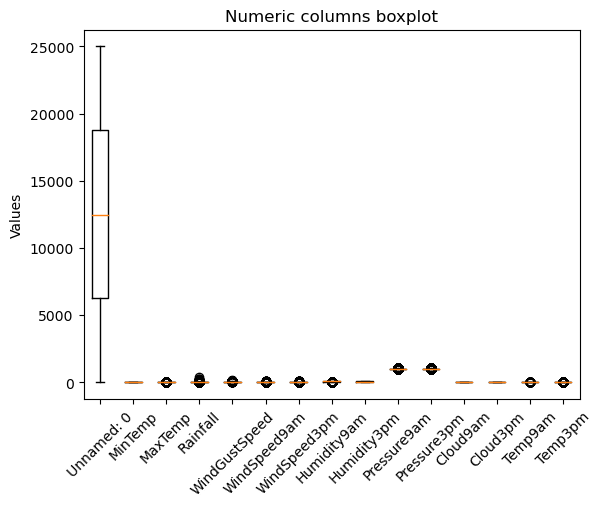

In [17]:
plot_numeric_columns_boxplot(df)

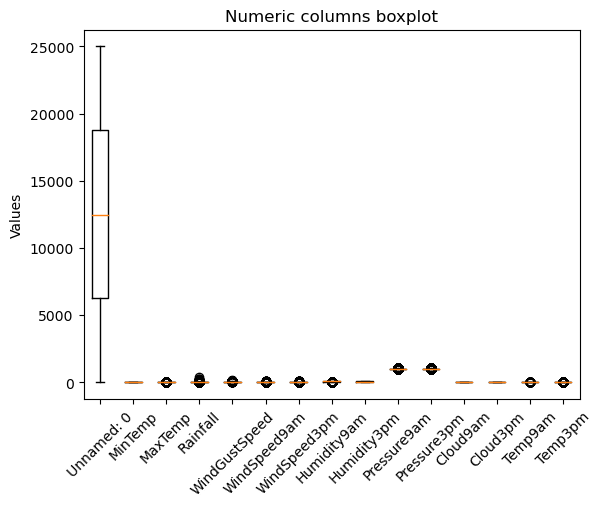

In [18]:
df = replace_outliers_with_mobile_mean(df, 'Rainfall', 3, 2)
plot_numeric_columns_boxplot(numeric_cols)

#### Data transformation
Functions to perform data types conversion and applying dummies to categoric variables.

In [20]:
# 'Date': from object to date-time
# 'RainToday' and 'RainTomorrow': from 'Yes'/No' to 'True'/'False'
def data_types_conversion(df, date_columns=[], bool_columns=[]):
    if date_columns:
        for col in date_columns:
            df[col] = pd.to_datetime(df[col])
    if bool_columns:
        for col in bool_columns:
            df[col] = df[col].map({'No': False, 'Yes': True})
    return df

def dummies_processing(df):
    cat_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
    X_cat = df[cat_cols]
    X_cat = pd.get_dummies(X_cat, drop_first=True)
    X_cat['RainToday'] = df['RainToday']
    X_cat['RainTomorrow'] = df['RainTomorrow']
    return X_cat

In [21]:
df = data_types_conversion(df, date_columns=['Date'], bool_columns=['RainToday', 'RainTomorrow'])
#print("NaN: \n", nan_values_check(df))
X_categoric = dummies_processing(df)
X_numeric = df[['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'Pressure9am', 'Pressure3pm']]
print(nan_values_check(X_categoric))

WindGustDir_ENE    0
WindGustDir_ESE    0
WindGustDir_N      0
WindGustDir_NE     0
WindGustDir_NNE    0
WindGustDir_NNW    0
WindGustDir_NW     0
WindGustDir_S      0
WindGustDir_SE     0
WindGustDir_SSE    0
WindGustDir_SSW    0
WindGustDir_SW     0
WindGustDir_W      0
WindGustDir_WNW    0
WindGustDir_WSW    0
WindDir9am_ENE     0
WindDir9am_ESE     0
WindDir9am_N       0
WindDir9am_NE      0
WindDir9am_NNE     0
WindDir9am_NNW     0
WindDir9am_NW      0
WindDir9am_S       0
WindDir9am_SE      0
WindDir9am_SSE     0
WindDir9am_SSW     0
WindDir9am_SW      0
WindDir9am_W       0
WindDir9am_WNW     0
WindDir9am_WSW     0
WindDir3pm_ENE     0
WindDir3pm_ESE     0
WindDir3pm_N       0
WindDir3pm_NE      0
WindDir3pm_NNE     0
WindDir3pm_NNW     0
WindDir3pm_NW      0
WindDir3pm_S       0
WindDir3pm_SE      0
WindDir3pm_SSE     0
WindDir3pm_SSW     0
WindDir3pm_SW      0
WindDir3pm_W       0
WindDir3pm_WNW     0
WindDir3pm_WSW     0
RainToday          0
RainTomorrow       0
dtype: int64


In [23]:
print(X_categoric.columns)
print(X_numeric.columns)

Index(['WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE',
       'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S',
       'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW',
       'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'RainToday', 'RainTomorrow'],
      dtype='object')
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3p

In [89]:
# pre-processed dataframe
X = pd.concat([X_numeric, X_categoric], axis=1)
print(X.head())

   MinTemp  MaxTemp  Rainfall  WindSpeed9am  WindSpeed3pm  Humidity9am   
0     13.4     22.9       0.6          20.0          24.0         71.0  \
1      7.4     25.1       0.0           4.0          22.0         44.0   
2     12.9     25.7       0.0          19.0          26.0         38.0   
3      9.2     28.0       0.0          11.0           9.0         45.0   
4     17.5     32.3       1.0           7.0          20.0         82.0   

   Humidity3pm  Temp9am  Temp3pm  Pressure9am  ...  WindDir3pm_S   
0         22.0     16.9     21.8       1007.7  ...         False  \
1         25.0     17.2     24.3       1010.6  ...         False   
2         30.0     21.0     23.2       1007.6  ...         False   
3         16.0     18.1     26.5       1017.6  ...         False   
4         33.0     17.8     29.7       1010.8  ...         False   

   WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  WindDir3pm_W   
0          False           False           False          False  

In [90]:
# salva il dataframe in formato JSON
X.to_json('ready_dataframe.json')